In [95]:
from fastai.vision.all import *

In [97]:
import fastai; fastai.__version__

'2.7.9'

In [2]:
top_edge = tensor([
    [-1,-1,-1],
    [ 0, 0, 0],
    [ 1, 1, 1]
]).float()
top_edge

tensor([[-1., -1., -1.],
        [ 0.,  0.,  0.],
        [ 1.,  1.,  1.]])

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
path.ls()

(#3) [Path('/home/jupyter/.fastai/data/mnist_sample/train'),Path('/home/jupyter/.fastai/data/mnist_sample/labels.csv'),Path('/home/jupyter/.fastai/data/mnist_sample/valid')]

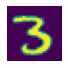

In [5]:
im3 = Image.open(path/'train'/'3'/'12.png'); 
show_image(im3);

In [6]:
im3_t = tensor(im3)
im3_t[0:3,0:3]

tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]], dtype=torch.uint8)

In [7]:
im3_t[0:3,0:3] * top_edge

tensor([[-0., -0., -0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [8]:
(im3_t[0:3,0:3] * top_edge).sum()

tensor(0.)

In [9]:
df = pd.DataFrame(im3_t[:10,:20])
df.style.background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


In [10]:
im3_t[4:7,6:9]

tensor([[  0,   0,   0],
        [142, 155, 246],
        [254, 254, 254]], dtype=torch.uint8)

In [11]:
(im3_t[4:7,6:9] * top_edge).sum()

tensor(762.)

In [12]:
im3_t[7:10,17:20]

tensor([[254,  75,   0],
        [254, 153,   0],
        [247,  53,   0]], dtype=torch.uint8)

In [13]:
(im3_t[7:10,17:20] * top_edge).sum()

tensor(-29.)

So our kernel is detecting top edges, in the sense that it returns big numbers when the pixel values are low at the top and high at the bottom 

In [14]:
def apply_kernel_at(row, col, kernel):
    """
    Apply kernel to to the image at (row, col)
    """
    # I made it more general, using the shape of the kernel 
    height, width = kernel.shape 
    return (im3_t[row-1:row + height-1, col-1: col + width-1] * kernel).sum()

In [15]:
apply_kernel_at(5,7,top_edge)

tensor(762.)

In [16]:
apply_kernel_at(7,2,top_edge)

tensor(-103.)

In [17]:
# this is a bottom edge, hence returning a large negative number 
apply_kernel_at(8,8,top_edge)

tensor(-613.)

## Mapping a Convolutional Kernel 

Lets apply our kernel to all possible positions in the grid instead of just one 

In [18]:
height, width = im3_t.shape
height, width

(28, 28)

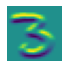

In [19]:
rng = range(1,27)
# apply our top_edge kernel to all positions 
top_edge3 = tensor([[apply_kernel_at(i,j,top_edge) for j in range(1,height-1)] for i in range(1,width-1)])
show_image(top_edge3);

In [20]:
top_edge3.min()

tensor(-762.)

In [21]:
def apply_kernel(im, kernel):
    height, width = im3_t.shape
    return tensor([[apply_kernel_at(i,j,kernel) for j in range(1,height-1)] for i in range(1,width-1)])

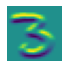

In [22]:
show_image(apply_kernel(im3_t, top_edge));

In [23]:
# odd that we're going -1,1,0 rather than -1,0,1 as with top edges 
left_edge = tensor([
    [-1,1,0],
    [-1,1,0],
    [-1,1,0]
]).float()
left_edge


tensor([[-1.,  1.,  0.],
        [-1.,  1.,  0.],
        [-1.,  1.,  0.]])

In [24]:
apply_kernel_at(7,3,left_edge)

tensor(393.)

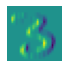

In [25]:
left_edge3 = apply_kernel(im3_t, left_edge)
show_image(left_edge3);

In [26]:
left_edge3.shape

torch.Size([26, 26])

Note how the size went from 28x28 image to a 26x26 image, since we only get to apply the kernel n - 2 times along a given axis

## Convolutions in PyTorch 

In [27]:
from torch.nn.functional import conv2d

In [28]:
F.conv2d == conv2d

True

* pytorch can apply a kernel to multiple images at once 
* pytorch can apply multiple kernels at once 

In [29]:
diag1_edge = tensor([
    [0,-1, 1],
    [-1,1, 0],
    [1, 0, 0]
]).float()
diag2_edge = tensor([
    [1,-1, 0],
    [0, 1,-1],
    [0, 0, 1]
])

In [30]:
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge]); edge_kernels

tensor([[[-1.,  1.,  0.],
         [-1.,  1.,  0.],
         [-1.,  1.,  0.]],

        [[-1., -1., -1.],
         [ 0.,  0.,  0.],
         [ 1.,  1.,  1.]],

        [[ 0., -1.,  1.],
         [-1.,  1.,  0.],
         [ 1.,  0.,  0.]],

        [[ 1., -1.,  0.],
         [ 0.,  1., -1.],
         [ 0.,  0.,  1.]]])

In [31]:
edge_kernels.shape

torch.Size([4, 3, 3])

In [32]:
mnist = DataBlock(
    (ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items = get_image_files,
    splitter = GrandparentSplitter(),
    get_y=parent_label
)

In [33]:
dls = mnist.dataloaders(path)

In [34]:
xb,yb = first(dls.valid)

In [35]:
xb.shape

torch.Size([64, 1, 28, 28])

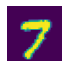

In [36]:
show_image(xb[3]);

In [37]:
xb,yb = to_cpu(xb), to_cpu(yb)

In [38]:
# (out_feature, channel, row, col)  
edge_kernels.shape, edge_kernels.unsqueeze(1).shape 

(torch.Size([4, 3, 3]), torch.Size([4, 1, 3, 3]))

In [39]:
edge_kernels = edge_kernels.unsqueeze(1)

In [42]:
edge_kernels.shape

torch.Size([4, 1, 3, 3])

In [40]:
batch_features = F.conv2d(xb, edge_kernels); batch_features.shape

torch.Size([64, 4, 26, 26])

In [82]:
# ^ batch, channel, height, width
#  or NCHW (where N = batch size)

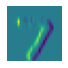

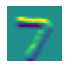

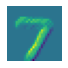

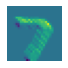

In [43]:
# left, top, diagonal (topleft -> bottomright), diagnonal (bottomleft -> topright)
for i in range(4):
    show_image(batch_features[0,i]);

## Our First Convolutional Neural Network 

In [44]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [45]:
simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [53]:
simple_net(torch.rand(28*28))

tensor([0.2031], grad_fn=<AddBackward0>)

In [55]:
broken_cnn = sequential(
    nn.Conv2d(1,30,kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30,1,kernel_size=3, padding=1)
)

The conv2d class doesn't need to know that we'll be passing in a 28x28 image. It can apply a 3x3 kernel to any image size, and in this case will produce another (or in our case 30, the output channel size) image of the same size as the input. With stride=2 we'd go down to a 14x14 image. 

In [63]:
broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])

The CNN produces a whole array of 28x28 numbers for each image in the batch, i.e. a whole new image. We want to do classification, so we need to find a way of getting down to one number 

In [64]:
def conv(ni, nf, ks=3, act=True):
    # making the padding half the kernel size ensures that the image dims are preserved in the case of stride=1, halved in the case of stride=2, etc.  
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2) 
    if act:
        res = nn.Sequential(res, nn.ReLU())
    return res

In [74]:
# assume input is 28x28
simple_cnn = sequential(
    # since our stride-2 conv layers halve the number of activations, we double the number of channels to keep a similar 
    # amount of info
    conv(1,4),            # 14x14
    conv(4,8),            # 7x7
    conv(8,16),           # 4x4
    conv(16,32),          # 2x2
    conv(32,2,act=False), # 1x1
    Flatten(),    
)

In [75]:
simple_cnn(xb).shape

torch.Size([64, 2])

In [77]:
learn = Learner(
    dls=dls,
    model=simple_cnn,
    loss_func=F.cross_entropy,
    metrics=accuracy
)

In [78]:
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

In [80]:
learn.fit_one_cycle(2,0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.052627,0.048006,0.988224,00:26
1,0.021285,0.023836,0.992149,00:07


In [85]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(32, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): fastai.layers.Flatten(full=False)
)

In [88]:
m = learn.model[0]
first_conv = m[0]
first_conv

Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

In [89]:
first_conv.weight.shape

torch.Size([4, 1, 3, 3])

In [93]:
first_conv.bias.shape

torch.Size([4])

## Color Images 

In [104]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

In [105]:
im = image2tensor(Image.open(image_bear()))
im.shape

torch.Size([3, 1000, 846])

In [107]:
im = image2tensor(Image.open(image_bear()))

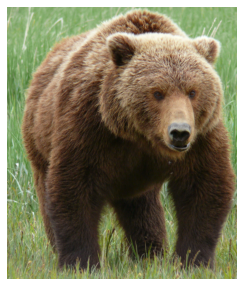

In [109]:
show_image(im);

In [110]:
im[0,:].shape

torch.Size([1000, 846])

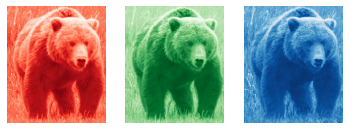

In [123]:
fig, ax = plt.subplots(1,3)
colors = ['Reds','Greens','Blues']
for i in range(3):
    show_image(255-im[i,:], ax=ax[i], cmap=colors[i]);

## Improving Training Stability 

In [124]:
path = untar_data(URLs.MNIST)

In [125]:
path.ls()

(#2) [Path('/home/jupyter/.fastai/data/mnist_png/testing'),Path('/home/jupyter/.fastai/data/mnist_png/training')]

In [129]:
(path/'training/5').ls()

(#5421) [Path('/home/jupyter/.fastai/data/mnist_png/training/5/32720.png'),Path('/home/jupyter/.fastai/data/mnist_png/training/5/24173.png'),Path('/home/jupyter/.fastai/data/mnist_png/training/5/13991.png'),Path('/home/jupyter/.fastai/data/mnist_png/training/5/8569.png'),Path('/home/jupyter/.fastai/data/mnist_png/training/5/44215.png'),Path('/home/jupyter/.fastai/data/mnist_png/training/5/22053.png'),Path('/home/jupyter/.fastai/data/mnist_png/training/5/21371.png'),Path('/home/jupyter/.fastai/data/mnist_png/training/5/58757.png'),Path('/home/jupyter/.fastai/data/mnist_png/training/5/37341.png'),Path('/home/jupyter/.fastai/data/mnist_png/training/5/42850.png')...]

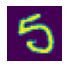

In [133]:
show_image(Image.open(path/'training/5/22053.png'));

In [142]:
get_image_files(path/'training')

(#60000) [Path('/home/jupyter/.fastai/data/mnist_png/training/6/494.png'),Path('/home/jupyter/.fastai/data/mnist_png/training/6/1538.png'),Path('/home/jupyter/.fastai/data/mnist_png/training/6/31368.png'),Path('/home/jupyter/.fastai/data/mnist_png/training/6/9517.png'),Path('/home/jupyter/.fastai/data/mnist_png/training/6/2138.png'),Path('/home/jupyter/.fastai/data/mnist_png/training/6/16695.png'),Path('/home/jupyter/.fastai/data/mnist_png/training/6/31867.png'),Path('/home/jupyter/.fastai/data/mnist_png/training/6/33513.png'),Path('/home/jupyter/.fastai/data/mnist_png/training/6/6029.png'),Path('/home/jupyter/.fastai/data/mnist_png/training/6/56988.png')...]

In [147]:
parent_label('/home/jupyter/.fastai/data/mnist_png/training/6/9517.png')

'6'

In [183]:
tensor_6 = tensor(Image.open('/home/jupyter/.fastai/data/mnist_png/training/6/9517.png')).float(); 2 * tensor_6

tensor([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  24., 340., 508., 508., 508., 510., 190.,  58.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  14., 308., 506., 506., 506., 506., 486., 472., 152.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  14., 336., 506., 506., 506., 506., 312., 114.,   0.,   0.,

In [186]:
Normalize()(20 + 2*tensor_6)

tensor([[ 20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.],
        [ 20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.],
        [ 20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.],
        [ 20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  44., 360., 528., 528., 528., 530., 210.,  78.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.],
        [ 20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  34., 328., 526., 526., 526., 526., 506., 492., 172.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.],
        [ 20.,  20.,  20.,  20.,  20.,  20.,  20.,  34., 356., 526., 526., 526., 526., 332., 134.,  20.,  20.,

In [172]:
def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
        get_items=get_image_files,
        splitter=GrandparentSplitter('training','testing'),
        get_y=parent_label,
        batch_tfms=Normalize()      
    ).dataloaders(path, bs=bs)

In [173]:
dls=get_dls()

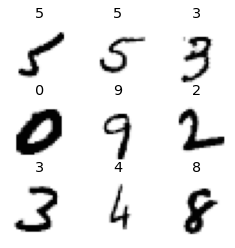

In [175]:
dls.show_batch(max_n=9, figsize=(4,4))